In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from dsfunctions import get_npts, get_nnd, get_ch_vol
import scipy.stats as stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import random
from sklearn.model_selection import train_test_split

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Load data
df = pd.read_csv('full_pc_directory.csv')

In [3]:
# Convert data to useful format
df = df[df['s_priority'] != 5]
df['trial']=df['trial_dir']
w_trials = ['Seedless_Watermelon_Variety_Trial', 'Personal-Sized_Watermelons']
df['trial'] = df['trial'].replace(w_trials, 'Watermelon_Variety_Trial')
print(df['trial'].unique())
df['npts'] = np.nan
df['nnd'] = np.nan
df['ch_vol'] = np.nan
df['npts_vol'] = np.nan

['Garden_Plots' 'Tomato_Fertilizer_Trial' 'Watermelon_Variety_Trial'
 'Transplant-Age_Plants' 'Pepper_Variety_Trial']


In [4]:
# Define function to process each row

def process_row(row):

    # Read in point cloud
    inf='{a}\{b}\{c}\sor_plant_{c}.ply'.format(a=row['trial_dir'],
                                            b=row['date_dir'],
                                            c=row['plot_id'])
    pcd = o3d.io.read_point_cloud(inf)
    
    # Get number of points
    npts = get_npts(pcd)

    # Get nearest neighbor distance
    nnd = get_nnd(pcd)

    # Get convex hull volume
    ch_vol = get_ch_vol(pcd)

    # Get n points per unit volume
    npts_vol = npts/ch_vol

    row['npts'] = npts
    row['nnd'] = nnd
    row['ch_vol'] = ch_vol
    row['npts_vol'] = npts_vol

    print(row['sample_id'], ' processed')

    return row

In [5]:
# Apply function to df
df = df.apply(process_row, axis=1)

gp_10_06_24_2023  processed
gp_10_08_02_2023  processed
gp_10_08_12_2023  processed
gp_10_08_25_2023  processed
gp_10_09_07_2023  processed
gp_10_09_14_2023  processed
gp_11_06_24_2023  processed
gp_11_08_02_2023  processed
gp_11_08_12_2023  processed
gp_11_08_25_2023  processed
gp_11_09_07_2023  processed
gp_11_09_14_2023  processed
gp_12_06_24_2023  processed
gp_13_06_24_2023  processed
gp_13_08_02_2023  processed
gp_14_06_24_2023  processed
gp_14_08_02_2023  processed
gp_15_06_24_2023  processed
gp_17_06_24_2023  processed
gp_17_08_02_2023  processed
gp_18_06_24_2023  processed
gp_18_07_07_2023  processed
gp_19_06_24_2023  processed
gp_19_08_02_2023  processed
gp_19_08_12_2023  processed
gp_19_08_25_2023  processed
gp_19_09_01_2023  processed
gp_20_06_24_2023  processed
gp_20_08_02_2023  processed
gp_20_08_12_2023  processed
gp_20_08_25_2023  processed
gp_20_09_07_2023  processed
gp_20_09_20_2023  processed
gp_20_10_02_2023  processed
gp_21_06_24_2023  processed
gp_21_07_07_2023  pr

In [6]:
print(df['npts'].describe())

count       295.000000
mean     243647.657627
std       99039.026093
min        8661.000000
25%      180549.000000
50%      230191.000000
75%      282787.000000
max      724749.000000
Name: npts, dtype: float64


In [7]:
# Create a df for each trial
gdf = df.loc[df['trial'] == 'Garden_Plots']
tdf = df.loc[df['trial'] == 'Tomato_Fertilizer_Trial']
wdf = df.loc[df['trial'] == 'Watermelon_Variety_Trial']
adf = df.loc[df['trial'] == 'Transplant-Age_Plants']
pdf = df.loc[df['trial'] == 'Pepper_Variety_Trial']

In [8]:
# Number of scans per trial
print('Garden Plot Scans: ', len(gdf))
print('Tomato Fertilizer Scans: ', len(tdf))
print('Watermelon Variety Scans: ', len(wdf))
print('Transplant-Age Plants Scans: ', len(adf))
print('Pepper Variety Scans: ', len(pdf))

Garden Plot Scans:  70
Tomato Fertilizer Scans:  74
Watermelon Variety Scans:  42
Transplant-Age Plants Scans:  5
Pepper Variety Scans:  104


In [9]:
# Average number of points per trial
print('Total Average Points: ', df['npts'].mean())
print('Garden Plot Average Points: ', gdf['npts'].mean())
print('Tomato Fertilizer Average Points: ', tdf['npts'].mean())
print('Watermelon Variety Average Points: ', wdf['npts'].mean())
print('Transplant-Age Plants Average Points: ', adf['npts'].mean())
print('Pepper Variety Average Points: ', pdf['npts'].mean())

Total Average Points:  243647.65762711863
Garden Plot Average Points:  211766.2
Tomato Fertilizer Average Points:  226284.5
Watermelon Variety Average Points:  266636.0714285714
Transplant-Age Plants Average Points:  102238.6
Pepper Variety Average Points:  274975.6153846154


In [10]:
# Average nearest neighbor distance per trial
print('Total Average NND: ', df['nnd'].mean())
print('Garden Plot Average NND: ', gdf['nnd'].mean())
print('Tomato Fertilizer Average NND: ', tdf['nnd'].mean())
print('Watermelon Variety Average NND: ', wdf['nnd'].mean())
print('Transplant-Age Plants Average NND: ', adf['nnd'].mean())
print('Pepper Variety Average NND: ', pdf['nnd'].mean())

Total Average NND:  0.0018257371856365738
Garden Plot Average NND:  0.0012923112774603904
Tomato Fertilizer Average NND:  0.0016383467305599666
Watermelon Variety Average NND:  0.0031287957019309537
Transplant-Age Plants Average NND:  0.0002477951080984423
Pepper Variety Average NND:  0.0018677368005531934


In [11]:
# Average convex hull volume per trial
print('Total Average CH Vol: ', df['ch_vol'].mean())
print('Garden Plot Average CH Vol: ', gdf['ch_vol'].mean())
print('Tomato Fertilizer Average CH Vol: ', tdf['ch_vol'].mean())
print('Watermelon Variety Average CH Vol: ', wdf['ch_vol'].mean())
print('Transplant-Age Plants Average CH Vol: ', adf['ch_vol'].mean())
print('Pepper Variety Average CH Vol: ', pdf['ch_vol'].mean())

Total Average CH Vol:  1.1369876432040786
Garden Plot Average CH Vol:  0.6115974922388904
Tomato Fertilizer Average CH Vol:  0.507278405745656
Watermelon Variety Average CH Vol:  3.960313477851975
Transplant-Age Plants Average CH Vol:  0.010682511021876796
Pepper Variety Average CH Vol:  0.8526379772924033


In [12]:
# Average number of points per unit volume per trial
print('Total Average Npts/Vol: ', df['npts_vol'].mean())
print('Garden Plot Average Npts/Vol: ', gdf['npts_vol'].mean())
print('Tomato Fertilizer Average Npts/Vol: ', tdf['npts_vol'].mean())
print('Watermelon Variety Average Npts/Vol: ', wdf['npts_vol'].mean())
print('Transplant-Age Plants Average Npts/Vol: ', adf['npts_vol'].mean())
print('Pepper Variety Average Npts/Vol: ', pdf['npts_vol'].mean())

Total Average Npts/Vol:  1938978.2274091474
Garden Plot Average Npts/Vol:  3216580.3688895795
Tomato Fertilizer Average Npts/Vol:  678326.343141979
Watermelon Variety Average Npts/Vol:  164600.00891907784
Transplant-Age Plants Average Npts/Vol:  11234348.343195448
Pepper Variety Average Npts/Vol:  2245739.036349451


In [13]:
# Get pearson r for npts and nnd
print('Total Pearson r: ', stats.pearsonr(df['npts'], df['nnd']))
print('Garden Plot Pearson r: ', stats.pearsonr(gdf['npts'], gdf['nnd']))
print('Tomato Fertilizer Pearson r: ', stats.pearsonr(tdf['npts'], tdf['nnd']))
print('Watermelon Variety Pearson r: ', stats.pearsonr(wdf['npts'], wdf['nnd']))
print('Transplant-Age Plants Pearson r: ', stats.pearsonr(adf['npts'], adf['nnd']))
print('Pepper Variety Pearson r: ', stats.pearsonr(pdf['npts'], pdf['nnd']))

Total Pearson r:  PearsonRResult(statistic=-0.09986882524485491, pvalue=0.08684062389865176)
Garden Plot Pearson r:  PearsonRResult(statistic=0.27240061528061266, pvalue=0.02252727478655255)
Tomato Fertilizer Pearson r:  PearsonRResult(statistic=-0.21549159712884502, pvalue=0.06519804002394722)
Watermelon Variety Pearson r:  PearsonRResult(statistic=-0.17471840230160782, pvalue=0.26843567262724405)
Transplant-Age Plants Pearson r:  PearsonRResult(statistic=-0.1552793642109918, pvalue=0.803089582935939)
Pepper Variety Pearson r:  PearsonRResult(statistic=-0.7592136354563681, pvalue=9.720040801794547e-21)


In [14]:
# Get spearman r for npts and nnd
print('Total Spearman r: ', stats.spearmanr(df['npts'], df['nnd']))
print('Garden Plot Spearman r: ', stats.spearmanr(gdf['npts'], gdf['nnd']))
print('Tomato Fertilizer Spearman r: ', stats.spearmanr(tdf['npts'], tdf['nnd']))
print('Watermelon Variety Spearman r: ', stats.spearmanr(wdf['npts'], wdf['nnd']))
print('Transplant-Age Plants Spearman r: ', stats.spearmanr(adf['npts'], adf['nnd']))
print('Pepper Variety Spearman r: ', stats.spearmanr(pdf['npts'], pdf['nnd']))

Total Spearman r:  SignificanceResult(statistic=-0.103390100471443, pvalue=0.07622897175442749)
Garden Plot Spearman r:  SignificanceResult(statistic=0.4085103404836056, pvalue=0.00044674757768475956)
Tomato Fertilizer Spearman r:  SignificanceResult(statistic=-0.2416604343674867, pvalue=0.03805122423867614)
Watermelon Variety Spearman r:  SignificanceResult(statistic=-0.1439915728060935, pvalue=0.3629471222277947)
Transplant-Age Plants Spearman r:  SignificanceResult(statistic=-0.39999999999999997, pvalue=0.5046315754686911)
Pepper Variety Spearman r:  SignificanceResult(statistic=-0.7948469006721435, pvalue=7.332816100642754e-24)


In [15]:
# Get pearson r for npts and ch_vol
print('Total Pearson r: ', stats.pearsonr(df['npts'], df['ch_vol']))
print('Garden Plot Pearson r: ', stats.pearsonr(gdf['npts'], gdf['ch_vol']))
print('Tomato Fertilizer Pearson r: ', stats.pearsonr(tdf['npts'], tdf['ch_vol']))
print('Watermelon Variety Pearson r: ', stats.pearsonr(wdf['npts'], wdf['ch_vol']))
print('Transplant-Age Plants Pearson r: ', stats.pearsonr(adf['npts'], adf['ch_vol']))
print('Pepper Variety Pearson r: ', stats.pearsonr(pdf['npts'], pdf['ch_vol']))

Total Pearson r:  PearsonRResult(statistic=0.10750707189615737, pvalue=0.06518271748284497)
Garden Plot Pearson r:  PearsonRResult(statistic=0.33725280905733523, pvalue=0.004303572663118179)
Tomato Fertilizer Pearson r:  PearsonRResult(statistic=0.3425852319447672, pvalue=0.002809623333636005)
Watermelon Variety Pearson r:  PearsonRResult(statistic=0.1270340322445465, pvalue=0.42273518650884007)
Transplant-Age Plants Pearson r:  PearsonRResult(statistic=0.8930977622912265, pvalue=0.04127856115017488)
Pepper Variety Pearson r:  PearsonRResult(statistic=-0.5987140399187377, pvalue=1.908253673088173e-11)


In [16]:
# Get spearman r for npts and ch_vol
print('Total Spearman r: ', stats.spearmanr(df['npts'], df['ch_vol']))
print('Garden Plot Spearman r: ', stats.spearmanr(gdf['npts'], gdf['ch_vol']))
print('Tomato Fertilizer Spearman r: ', stats.spearmanr(tdf['npts'], tdf['ch_vol']))
print('Watermelon Variety Spearman r: ', stats.spearmanr(wdf['npts'], wdf['ch_vol']))
print('Transplant-Age_Plants Spearman r: ', stats.spearmanr(adf['npts'], adf['ch_vol']))
print('Pepper Variety Spearman r: ', stats.spearmanr(pdf['npts'], pdf['ch_vol']))

Total Spearman r:  SignificanceResult(statistic=0.15868801547019826, pvalue=0.006308263058273874)
Garden Plot Spearman r:  SignificanceResult(statistic=0.5660846135003674, pvalue=3.268811112052243e-07)
Tomato Fertilizer Spearman r:  SignificanceResult(statistic=0.46557916016944767, pvalue=2.9158950739223898e-05)
Watermelon Variety Spearman r:  SignificanceResult(statistic=0.48140345190827327, pvalue=0.0012482860428895297)
Transplant-Age_Plants Spearman r:  SignificanceResult(statistic=0.6, pvalue=0.28475697986529375)
Pepper Variety Spearman r:  SignificanceResult(statistic=-0.4490984743411928, pvalue=1.7369417597373388e-06)


In [17]:
# Get pearson r for nnd and ch_vol
print('Total Pearson r: ', stats.pearsonr(df['nnd'], df['ch_vol']))
print('Garden Plot Pearson r: ', stats.pearsonr(gdf['nnd'], gdf['ch_vol']))
print('Tomato Fertilizer Pearson r: ', stats.pearsonr(tdf['nnd'], tdf['ch_vol']))
print('Watermelon Variety Pearson r: ', stats.pearsonr(wdf['nnd'], wdf['ch_vol']))
print('Transplant-Age Plants Pearson r: ', stats.pearsonr(adf['nnd'], adf['ch_vol']))
print('Pepper Variety Pearson r: ', stats.pearsonr(pdf['nnd'], pdf['ch_vol']))

Total Pearson r:  PearsonRResult(statistic=0.7637052313769748, pvalue=1.2491089859598834e-57)
Garden Plot Pearson r:  PearsonRResult(statistic=0.8865174181333064, pvalue=1.8827306991097336e-24)
Tomato Fertilizer Pearson r:  PearsonRResult(statistic=0.7341143641170127, pvalue=9.929528005308792e-14)
Watermelon Variety Pearson r:  PearsonRResult(statistic=0.8942014028828766, pvalue=1.5216890696985733e-15)
Transplant-Age Plants Pearson r:  PearsonRResult(statistic=0.2644261845768191, pvalue=0.6672878266025944)
Pepper Variety Pearson r:  PearsonRResult(statistic=0.9276019768634695, pvalue=2.044027644348291e-45)


In [18]:
# Get spearman r for nnd and ch_vol
print('Total Spearman r: ', stats.spearmanr(df['nnd'], df['ch_vol']))
print('Garden Plot Spearman r: ', stats.spearmanr(gdf['nnd'], gdf['ch_vol']))
print('Tomato Fertilizer Spearman r: ', stats.spearmanr(tdf['nnd'], tdf['ch_vol']))
print('Watermelon Variety Spearman r: ', stats.spearmanr(wdf['nnd'], wdf['ch_vol']))
print('Transplant-Age Plants Spearman r: ', stats.spearmanr(adf['nnd'], adf['ch_vol']))
print('Pepper Variety Spearman r: ', stats.spearmanr(pdf['nnd'], pdf['ch_vol']))

Total Spearman r:  SignificanceResult(statistic=0.896368949388351, pvalue=1.5858257956767235e-105)
Garden Plot Spearman r:  SignificanceResult(statistic=0.9342828148511041, pvalue=3.5931481920455165e-32)
Tomato Fertilizer Spearman r:  SignificanceResult(statistic=0.5190225842280636, pvalue=2.1611246415596646e-06)
Watermelon Variety Spearman r:  SignificanceResult(statistic=0.6993760635280772, pvalue=2.5675554096773816e-07)
Transplant-Age Plants Spearman r:  SignificanceResult(statistic=0.19999999999999998, pvalue=0.747060078104662)
Pepper Variety Spearman r:  SignificanceResult(statistic=0.783015043209218, pvalue=9.268823998687664e-23)


In [19]:
print(df.columns)

Index(['plot_id', 'date_dir', 'trial_dir', 'file_path', 'date', 'sample_id',
       'species', 'scan_level', 'plants_per_group', 'group_proportion',
       'bounding_width', 'bounding_depth', 'bounding_height', 'hue',
       'saturation', 'value', 'k_neighbors', 'n_std_ratio', 'k_s',
       's_std_ratio', 'problem', 'problem_type', 's_priority', 'trial', 'npts',
       'nnd', 'ch_vol', 'npts_vol'],
      dtype='object')


In [20]:
# Save points df
df.drop(['file_path', 'bounding_width', 'bounding_depth', 'bounding_height', 'hue',
         'saturation', 'value', 'k_neighbors', 'n_std_ratio', 'k_s', 's_std_ratio',
         'problem', 'problem_type'], axis=1, inplace=True)
df.to_csv('pts_directory.csv', index=False)

In [21]:
# Create summary stats df
s_cols = ['trial', 'samples', 'npts', 'npts_sd', 
          'nnd', 'nnd_sd', 'ch_vol', 'ch_vol_sd', 'npts_vol', 'npts_vol_sd',
          'r_npts_nnd', 'r_npts_ch_vol', 'r_nnd_ch_vol', 'r_npts_vol_nnd',
           'p_npts_nnd', 'p_npts_ch_vol', 'p_nnd_ch_vol', 'p_npts_vol_nnd']
summary_df = pd.DataFrame(columns=s_cols)

In [22]:
# Create species-level dfs
tadf = df.loc[df['species'] == 'tomato']
wadf = df.loc[df['species'] == 'watermelon']

In [23]:
# Define function to process each trial

def process_trial(trialdf, trial_name):
    global summary_df, s_cols

    row = pd.DataFrame(columns=s_cols)
    row['trial'] = [trial_name]
    row['samples'] = [len(trialdf)]
    row['npts'] = [trialdf['npts'].mean()]
    row['npts_sd'] = [trialdf['npts'].std()]
    row['nnd'] = [trialdf['nnd'].mean()]
    row['nnd_sd'] = [trialdf['nnd'].std()]
    row['ch_vol'] = [trialdf['ch_vol'].mean()]
    row['ch_vol_sd'] = [trialdf['ch_vol'].std()]
    row['npts_vol'] = [trialdf['npts_vol'].mean()]
    row['npts_vol_sd'] = [trialdf['npts_vol'].std()]
    row['r_npts_nnd'] = [stats.pearsonr(trialdf['npts'], trialdf['nnd'])[0]]
    row['r_npts_ch_vol'] = [stats.pearsonr(trialdf['npts'], trialdf['ch_vol'])[0]]
    row['r_nnd_ch_vol'] = [stats.pearsonr(trialdf['nnd'], trialdf['ch_vol'])[0]]
    row['r_npts_vol_nnd'] = [stats.pearsonr(trialdf['npts_vol'], trialdf['nnd'])[0]]
    row['p_npts_nnd'] = [stats.pearsonr(trialdf['npts'], trialdf['nnd'])[1]]
    row['p_npts_ch_vol'] = [stats.pearsonr(trialdf['npts'], trialdf['ch_vol'])[1]]
    row['p_nnd_ch_vol'] = [stats.pearsonr(trialdf['nnd'], trialdf['ch_vol'])[1]]
    row['p_npts_vol_nnd'] = [stats.pearsonr(trialdf['npts_vol'], trialdf['nnd'])[1]]

    summary_df = pd.concat([row, summary_df], ignore_index=True)

    return

In [24]:
# Apply function to each trial
trial_list = [[df, 'All_Scans'],
              [gdf, 'Garden_Plots'],
              [tdf, 'Tomato_Fertilizer_Trial'],
              [wdf, 'Watermelon_Variety_Trial'],
              [adf, 'Transplant-Age_Plants'],
              [pdf, 'Pepper_Variety_Trial'],
              [tadf, 'All_Tomato'],
              [wadf, 'All_Watermelon']]

for trial in trial_list:
    process_trial(trial[0], trial[1])

summary_df['npts'] = summary_df['npts'].astype(int)
summary_df['npts_sd'] = summary_df['npts_sd'].astype(int)
summary_df['nnd'] = summary_df['nnd'].round(5)
summary_df['nnd_sd'] = summary_df['nnd_sd'].round(5)
summary_df['ch_vol'] = summary_df['ch_vol'].round(3)
summary_df['ch_vol_sd'] = summary_df['ch_vol_sd'].round(3)
summary_df['npts_vol'] = summary_df['npts_vol'].round(3)
summary_df['npts_vol_sd'] = summary_df['npts_vol_sd'].round(3)
summary_df['r_npts_nnd'] = summary_df['r_npts_nnd'].round(2)
summary_df['r_npts_ch_vol'] = summary_df['r_npts_ch_vol'].round(2)
summary_df['r_nnd_ch_vol'] = summary_df['r_nnd_ch_vol'].round(2)
summary_df['r_npts_vol_nnd'] = summary_df['r_npts_vol_nnd'].round(2)
summary_df['p_npts_nnd'] = summary_df['p_npts_nnd'].round(3)
summary_df['p_npts_ch_vol'] = summary_df['p_npts_ch_vol'].round(3)
summary_df['p_nnd_ch_vol'] = summary_df['p_nnd_ch_vol'].round(3)
summary_df['p_npts_vol_nnd'] = summary_df['p_npts_vol_nnd'].round(3)


C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\2505801450.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([row, summary_df], ignore_index=True)


In [25]:
print(summary_df)

                      trial samples    npts  npts_sd      nnd   nnd_sd  \
0            All_Watermelon      66  241668   144979  0.00247  0.00175   
1                All_Tomato     125  218627    75923  0.00145  0.00060   
2      Pepper_Variety_Trial     104  274975    77720  0.00187  0.00116   
3     Transplant-Age_Plants       5  102238    38856  0.00025  0.00005   
4  Watermelon_Variety_Trial      42  266636   133520  0.00313  0.00168   
5   Tomato_Fertilizer_Trial      74  226284    72222  0.00164  0.00046   
6              Garden_Plots      70  211766   109421  0.00129  0.00085   
7                 All_Scans     295  243647    99039  0.00183  0.00121   

   ch_vol  ch_vol_sd      npts_vol  npts_vol_sd  r_npts_nnd  r_npts_ch_vol  \
0   2.860      4.424  2.116557e+06  5953473.772        0.13           0.21   
1   0.464      0.291  1.589992e+06  3446183.442        0.04           0.33   
2   0.853      0.668  2.245739e+06  2807451.080       -0.76          -0.60   
3   0.011      0.008 

In [26]:
# Save summary df
summary_df.to_csv('summary_stats.csv', index=False)

In [27]:
df = pd.read_csv('pts_directory.csv')

In [28]:
# Convert nearest neighbor distance to mm
df['nnd'] = df['nnd']*1000

In [29]:
# create species-level dfs
tadf = df.loc[df['species'] == 'tomato']
wadf = df.loc[df['species'] == 'watermelon']
pdf = df.loc[df['species'] == 'pepper']

In [30]:
print(wadf['nnd'].describe())

count    66.000000
mean      2.470798
std       1.748011
min       0.183305
25%       1.273340
50%       2.264849
75%       3.329940
max       6.166098
Name: nnd, dtype: float64


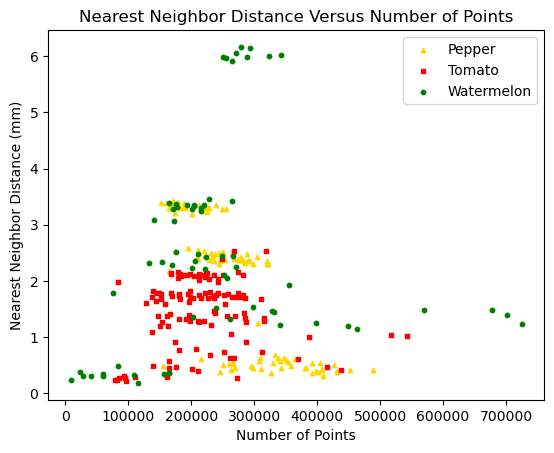

In [31]:
# Plot npts vs nnd for each trial
fig, ax = plt.subplots()
marker_size = 10
ax.scatter(pdf['npts'], pdf['nnd'], marker="^", color='gold', label='Pepper', s=marker_size)
ax.scatter(tadf['npts'], tadf['nnd'], marker="s", color='red', label='Tomato', s=marker_size)
ax.scatter(wadf['npts'], wadf['nnd'], marker="o", color='green', label='Watermelon', s=marker_size)
ax.set_xlabel('Number of Points')
ax.set_ylabel('Nearest Neighbor Distance (mm)')
ax.set_title('Nearest Neighbor Distance Versus Number of Points')
ax.legend()
plt.savefig('plot_figs\\npts_nnd.jpg', dpi=300)

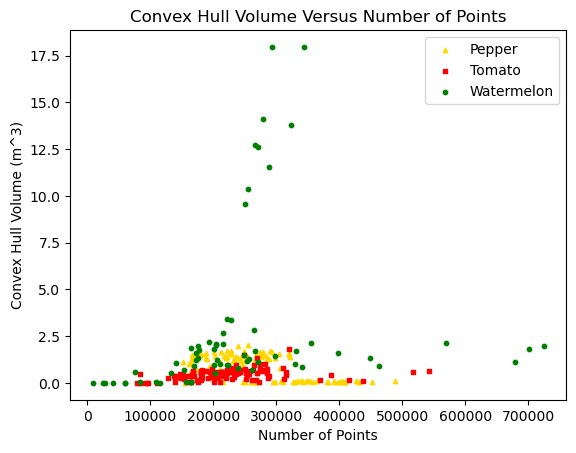

In [32]:
# Plot npts vs ch_vol for each trial
fig, ax = plt.subplots()
marker_size = 10
ax.scatter(pdf['npts'], pdf['ch_vol'], marker="^", color='gold', label='Pepper', s=marker_size)
ax.scatter(tadf['npts'], tadf['ch_vol'], marker="s", color='red', label='Tomato', s=marker_size)
ax.scatter(wadf['npts'], wadf['ch_vol'], marker="o", color='green', label='Watermelon', s=marker_size)
ax.set_xlabel('Number of Points')
ax.set_ylabel('Convex Hull Volume (m^3)')
ax.set_title('Convex Hull Volume Versus Number of Points')
ax.legend()
plt.savefig('plot_figs\\npts_ch_vol.jpg', dpi=300)

In [179]:
# Define power function
def func(x, a, b, c):
    return a * x**b - c

In [191]:
# Run curve fit for ch_vol vs nnd
xdata = df['ch_vol']
ydata = df['nnd']
popta, pcov = curve_fit(func, xdata, ydata)
print(popta)
# get r2
y_pred = func(xdata, *popta)
r2 = r2_score(ydata, y_pred)
print(r2)

[2.64386974 0.34544621 0.42284664]
0.8772152728955337


In [192]:
# Set test and train splits
random.seed(42)
train_size = 0.8
test_size = 0.2
X1_train, X1_test, y1_train, y1_test = train_test_split(df['ch_vol'], df['nnd'], train_size=train_size, test_size=test_size)

popta, pcov = curve_fit(func, X1_train, y1_train)
r2a = r2_score(y1_test, func(X1_test, *popta))
rmsea = np.sqrt(np.mean((y1_test - func(X1_test, *popta))**2))
# create a string for r2a with 2 decimal places
r2s = format(r2a, '.2f')
# create a string for rmsea with 2 decimal places
rmses = format(rmsea, '.2f')
print(r2s)
print(rmses)

0.90
0.30


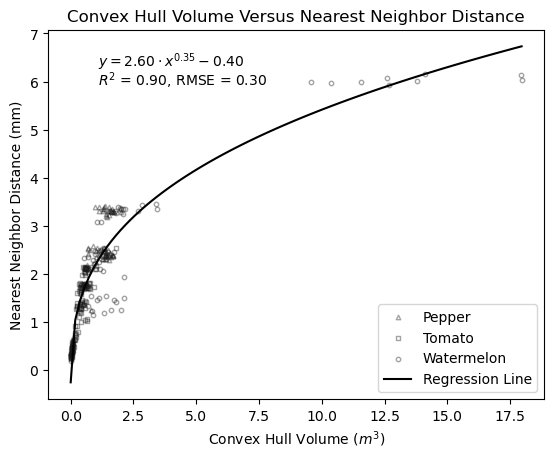

In [194]:
# Plot nnd vs ch_vol for each trial
fig, ax = plt.subplots()
marker_size = 10
lx = np.linspace(xdata.min(), xdata.max(), 100)
facecolor_translucent = (0.1, 0.1, 0.1, 0.001)
edgecolor_translucent = (0.1, 0.1, 0.1, 0.4)
ax.scatter(pdf['ch_vol'],pdf['nnd'],  
           marker="^", 
           facecolors=facecolor_translucent,
           edgecolors=edgecolor_translucent,
           label='Pepper', 
           s=marker_size)
ax.scatter(tadf['ch_vol'], tadf['nnd'], 
           marker="s", 
           facecolors=facecolor_translucent,
           edgecolors=edgecolor_translucent,
           label='Tomato', 
           s=marker_size)
ax.scatter(wadf['ch_vol'], wadf['nnd'], 
           marker="o", 
           facecolors=facecolor_translucent,
           edgecolors=edgecolor_translucent,
           label='Watermelon', 
           s=marker_size)
ax.plot(lx, func(lx, *popta), 'k-', label='Regression Line')
ax.set_ylabel('Nearest Neighbor Distance (mm)')
ax.set_xlabel('Convex Hull Volume ($m^3$)')
ax.set_title('Convex Hull Volume Versus Nearest Neighbor Distance')
# Add legend to bottom right of the plot
ax.legend(loc='lower right')
# Add equation to left of the plot
eq = r'$y = {a:.2f} \cdot x^{{{b:.2f}}} - {c:.2f}$'.format(a=popta[0], b=popta[1], c=popta[2])
# Add r2 value to left of the plot
r2 = '$R^2$ = {r}, RMSE = {rmse}'.format(r=r2s, rmse=rmses)
ax.text(0.10, 0.9, eq, ha='left', va='baseline', transform=ax.transAxes)
ax.text(0.10, 0.85, r2, ha='left', va='baseline', transform=ax.transAxes)
plt.savefig('plot_figs\\nnd_ch_vol.jpg', dpi=300)

In [86]:
# Create a column for log npts_vol
df['log_npts_vol'] = np.log10(df['npts_vol'])
pdf['log_npts_vol'] = np.log10(pdf['npts_vol'])
tadf['log_npts_vol'] = np.log10(tadf['npts_vol'])
wadf['log_npts_vol'] = np.log10(wadf['npts_vol'])
# Create a column for log ch_vol
df['log_ch_vol'] = np.log10(df['ch_vol'])
pdf['log_ch_vol'] = np.log10(pdf['ch_vol'])
tadf['log_ch_vol'] = np.log10(tadf['ch_vol'])
wadf['log_ch_vol'] = np.log10(wadf['ch_vol'])

C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\4014877959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['log_npts_vol'] = np.log10(pdf['npts_vol'])
C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\4014877959.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tadf['log_npts_vol'] = np.log10(tadf['npts_vol'])
C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\4014877959.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [49]:
# add a column for npts_vol for cm3 instead of m3
df['npts_vol_cm3'] = df['npts_vol']/1000000
pdf['npts_vol_cm3'] = pdf['npts_vol']/1000000
tadf['npts_vol_cm3'] = tadf['npts_vol']/1000000
wadf['npts_vol_cm3'] = wadf['npts_vol']/1000000

C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\3690882299.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['npts_vol_cm3'] = pdf['npts_vol']/1000000
C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\3690882299.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tadf['npts_vol_cm3'] = tadf['npts_vol']/1000000
C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\3690882299.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [87]:
# create a column for log npts_vol_cm3
df['log_npts_vol_cm3'] = np.log10(df['npts_vol_cm3'])
pdf['log_npts_vol_cm3'] = np.log10(pdf['npts_vol_cm3'])
tadf['log_npts_vol_cm3'] = np.log10(tadf['npts_vol_cm3'])
wadf['log_npts_vol_cm3'] = np.log10(wadf['npts_vol_cm3'])

C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\1776444184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf['log_npts_vol_cm3'] = np.log10(pdf['npts_vol_cm3'])
C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\1776444184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tadf['log_npts_vol_cm3'] = np.log10(tadf['npts_vol_cm3'])
C:\Users\Steven\AppData\Local\Temp\ipykernel_8848\1776444184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [88]:
# Define power function 2
def func2(x, a, b, c):
    return a * x**b + c

In [152]:
# Run curve fit for ch_vol vs log_npts_vol
xdata = df['ch_vol']
ydata = df['log_npts_vol']
popta, pcov = curve_fit(func2, xdata, ydata)
print(popta)
# get r2
y_pred = func2(xdata, *popta)
r2 = r2_score(ydata, y_pred)
print(r2)

[-5.33208533  0.08217316 10.73466997]
0.9367412762555559


In [165]:
# Set test and train splits
random.seed(42)
train_size = 0.8
test_size = 0.2
X1_train, X1_test, y1_train, y1_test = train_test_split(df['ch_vol'], df['log_npts_vol'], train_size=train_size, test_size=test_size)

popta, pcov = curve_fit(func2, X1_train, y1_train)
r2a = r2_score(y1_test, func2(X1_test, *popta))
rmsea = np.sqrt(np.mean((y1_test - func2(X1_test, *popta))**2))
# create a string for r2a with 2 decimal places
r2s = format(r2a, '.2f')
# create a string for rmsea with 2 decimal places
rmses = format(rmsea, '.2f')
print(r2s)
print(rmses)

0.95
0.15


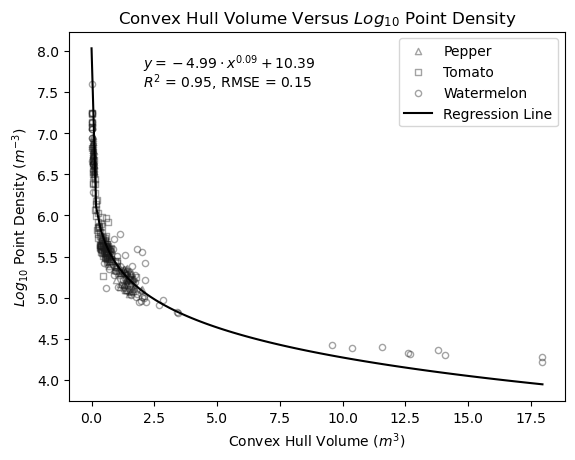

In [166]:
# Plot ch_vol vs log_npts_vol for each trial

fig, ax = plt.subplots()
marker_size = 20
lx = np.linspace(xdata.min(), xdata.max(), 100)
facecolor_translucent = (0.1, 0.1, 0.1, 0.001)
edgecolor_translucent = (0.1, 0.1, 0.1, 0.4)
ax.scatter(pdf['ch_vol'],pdf['log_npts_vol'],  
           marker="^", 
           facecolors=facecolor_translucent,
           edgecolors=edgecolor_translucent,
           label='Pepper', 
           s=marker_size)
ax.scatter(tadf['ch_vol'], tadf['log_npts_vol'], 
           marker="s", 
           facecolors=facecolor_translucent,
           edgecolors=edgecolor_translucent,
           label='Tomato', 
           s=marker_size)
ax.scatter(wadf['ch_vol'], wadf['log_npts_vol'], 
           marker="o", 
           facecolors=facecolor_translucent,
           edgecolors=edgecolor_translucent,
           label='Watermelon', 
           s=marker_size)
ax.plot(lx, func2(lx, *popta), 'k-', label='Regression Line')
ax.set_xlabel('Convex Hull Volume ($m^3$)')
ax.set_ylabel('$Log_{10}$ Point Density ($m^{-3}$)')
ax.set_title('Convex Hull Volume Versus $Log_{10}$ Point Density')

# Add equation to left of the plot
eq = r'$y = {a:.2f} \cdot x^{{{b:.2f}}} + {c:.2f}$'.format(a=popta[0], b=popta[1], c=popta[2])
# Add r2 value to left of the plot
r2a = '$R^2$ = {r}, RMSE = {rmse}'.format(r=r2s, rmse=rmses)
ax.text(0.15, 0.9, eq, ha='left', va='baseline', transform=ax.transAxes)
ax.text(0.15, 0.85, r2a, ha='left', va='baseline', transform=ax.transAxes)

ax.legend()
plt.savefig('plot_figs\\ch_vol_log_npts_vol.jpg', dpi=300)

In [36]:
# Run curve fit for npts vs nnd
xdata = df['npts_vol']
ydata = df['nnd']
poptb, pcov = curve_fit(func, xdata, ydata)
print(poptb)

[ 5.17153305e+02 -4.42481926e-01]


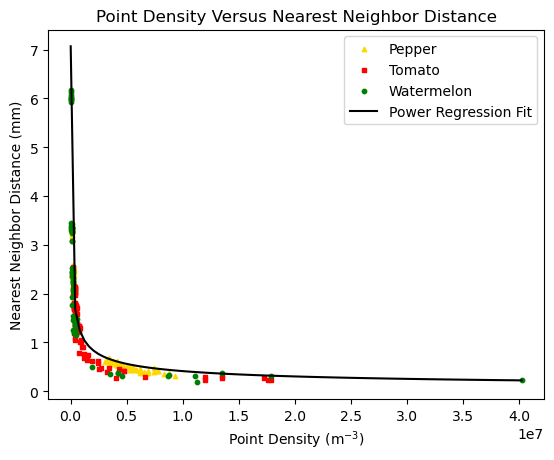

In [37]:
# Plot npts_vol vs nnd for each trial
fig, ax = plt.subplots()
marker_size = 10
lx = np.linspace(xdata.min(), xdata.max(), 100)
ax.scatter(pdf['npts_vol'], pdf['nnd'], marker="^", color='gold', label='Pepper', s=marker_size)
ax.scatter(tadf['npts_vol'], tadf['nnd'], marker="s", color='red', label='Tomato', s=marker_size)
ax.scatter(wadf['npts_vol'], wadf['nnd'], marker="o", color='green', label='Watermelon', s=marker_size)
ax.plot(lx, func(lx, *poptb), 'k-', label='Power Regression Fit')
ax.set_xlabel('Point Density (m$^{-3}$)')
ax.set_ylabel('Nearest Neighbor Distance (mm)')
ax.set_title('Point Density Versus Nearest Neighbor Distance')
ax.legend()
plt.savefig('plot_figs\\npts_vol_nnd.jpg', dpi=300)

In [38]:
# Set test and train splits
random.seed(42)
train_size = 0.8
test_size = 0.2
X1_train, X1_test, y1_train, y1_test = train_test_split(df['ch_vol'], df['nnd'], train_size=train_size, test_size=test_size)
X2_train, X2_test, y2_train, y2_test = train_test_split(df['npts_vol'], df['nnd'], train_size=train_size, test_size=test_size)

In [39]:
# Get r2 scores and rmse for both fits
popta, pcov = curve_fit(func, X1_train, y1_train)
r2a = r2_score(y1_test, func(X1_test, *popta))
print('r2 for nnd vs ch_vol: ', r2a)
rmsea = np.sqrt(np.mean((y1_test - func(X1_test, *popta))**2))
print('rmse for nnd vs ch_vol: ', rmsea)
poptb, pcov = curve_fit(func, X2_train, y2_train)
r2b = r2_score(y2_test, func(X2_test, *poptb))
print('r2 for nnd vs npts_vol: ', r2b)
rmseb = np.sqrt(np.mean((y2_test - func(X2_test, *poptb))**2))
print('rmse for nnd vs npts_vol: ', rmseb)

r2 for nnd vs ch_vol:  0.8836732616402154
rmse for nnd vs ch_vol:  0.4209217473429475
r2 for nnd vs npts_vol:  0.9423949141495661
rmse for nnd vs npts_vol:  0.2731876478977394


In [40]:
# Create fit df
fit_df = pd.DataFrame(columns=['x', 'y', 'a', 'b', 'r2', 'rmse'])
fit_df['x'] = ['ch_vol', 'npts_vol']
fit_df['y'] = ['nnd', 'nnd']
fit_df['a'] = [popta[0], poptb[0]]
fit_df['b'] = [popta[1], poptb[1]]
fit_df['r2'] = [r2a, r2b]
fit_df['rmse'] = [rmsea, rmseb]

# Save fit df
fit_df.to_csv('fit_df.csv', index=False)